In [1]:
import pandas as pd
import os
import librosa
import soundfile as sf
from IPython.display import Audio, display
import os
import numpy as np
import pandas as pd
import librosa

from sklearn.model_selection import train_test_split
import scipy
import pywt
import torchaudio
import parselmouth
from python_speech_features import mfcc
from spafe.features.lfcc import lfcc
import torch
from torchaudio.transforms import MFCC as TorchMFCC
from torchaudio.transforms import Spectrogram, MelSpectrogram
from scipy.signal import welch
from matplotlib import pyplot as plt
import parselmouth
from omegaconf import OmegaConf
import os
from ASV_func import prepare_filepath, listen_voice_flac, mfcc_feat, plot_coeff_histograms_by_label_separately, extract_cqcc, compute_gtcc, compute_wpt, analyze_formants_and_vtl

Metadata path: I:/Downloads/PA-keys-full/keys/PA/CM/trial_metadata.txt
FLAC folder: I:/Downloads/ASVspoof2021_PA_eval/flac


In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
config = OmegaConf.load("config.yaml")

meta = config.paths.metadata_path
flac = config.paths.flac_folder

In [4]:
cols = [
    "speaker_id", "file_id", "replay_device", "mic", "scene", "record_id",
    "mic_model", "scene_setup", "channel_config", "label", "trim", "set"
]

In [5]:
df = pd.read_csv(meta, sep=" ", header=None, names=cols)

In [6]:
df.head()

,speaker_id,file_id,replay_device,mic,scene,record_id,mic_model,scene_setup,channel_config,label,trim,set
0,PA_0010,PA_E_1000001,R3,M3,d4,r1,m1,s4,c4,spoof,notrim,eval
1,PA_0040,PA_E_1000002,R9,M3,d3,r9,m2,s4,c4,spoof,notrim,eval
2,PA_0037,PA_E_1000017,R2,M3,d5,r3,m3,s3,c2,spoof,notrim,eval
3,PA_0015,PA_E_1000018,R8,M2,d3,r7,m3,s2,c3,spoof,notrim,eval
4,PA_0028,PA_E_1000038,R3,M2,d3,r2,m1,s4,c2,spoof,notrim,eval


In [7]:
df = prepare_filepath(df)
df = df[:10000]

In [9]:
listen_voice_flac(df)

1. BONAFIDE — PA_E_1001324.flac


2. BONAFIDE — PA_E_1000298.flac


3. SPOOF — PA_E_1001175.flac


4. SPOOF — PA_E_1000235.flac


5. SPOOF — PA_E_1001262.flac


# MFCC – Mel-Frequency Cepstral Coefficients

MFCC (Mel-Frequency Cepstral Coefficients) to zbiór cech szeroko stosowanych w analizie dźwięku, 
szczególnie w rozpoznawaniu mowy i detekcji deepfake'ów. Odzwierciedlają one właściwości sygnału 
akustycznego w sposób zbliżony do percepcji ludzkiego słuchu.

Proces ekstrakcji MFCC składa się z następujących etapów:
1. Transformata Fouriera (FFT) – zamiana sygnału z dziedziny czasu na dziedzinę częstotliwości.
2. Obliczenie logarytmu widma mocy – uwzględnienie dynamiki słuchu.
3. Zastosowanie filtrów w skali mel – odwzorowanie czułości ucha ludzkiego.
4. Transformata cosinusowa (DCT) – kompresja informacji i redukcja wymiarowości.

Efektem końcowym są współczynniki, które dobrze opisują barwę i strukturę dźwięku, 
zachowując istotne informacje akustyczne, a jednocześnie redukując szum i redundancję.


In [65]:
df['MFCC'] = df['file_path'].apply(mfcc_feat)

In [66]:
df['MFCC'].head()

22        [-231.64218, 122.52767, 11.903803, 12.150235, ...
29        [-199.89511, 88.84366, 10.392325, 24.382372, -...
35        [-303.3729, 121.19909, 20.393871, 27.223604, 3...
40        [-269.06387, 111.45045, 4.4682155, 25.38466, 3...
93        [-196.17865, 109.13235, -12.636566, 35.54268, ...
                                ...                        
139620    [-265.13547, 78.30114, 12.430294, 33.301876, 6...
139623    [-237.70294, 117.020615, 13.779363, 34.67646, ...
139639    [-226.76369, 106.425316, 7.7085786, 14.018033,...
139647    [-222.95686, 141.4581, -12.600631, 25.32651, -...
139658    [-259.65958, 106.88462, 16.290796, 32.131355, ...
Name: MFCC, Length: 10000, dtype: object

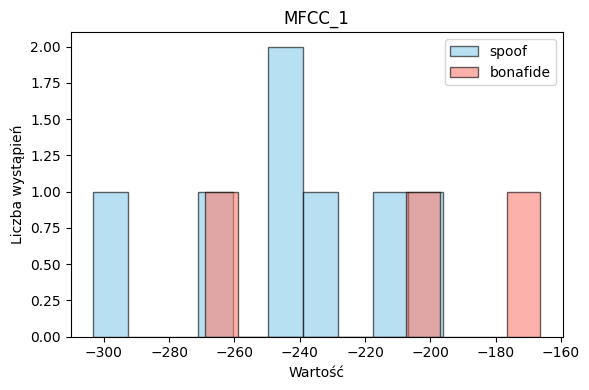

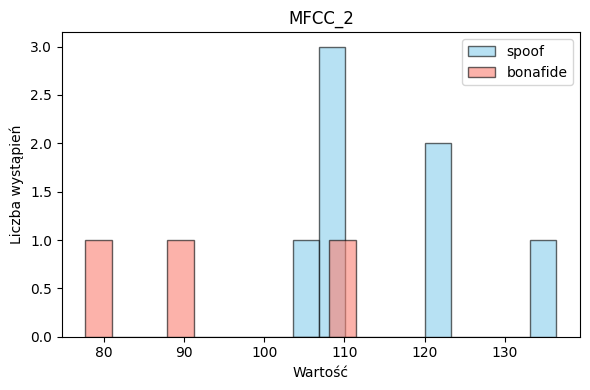

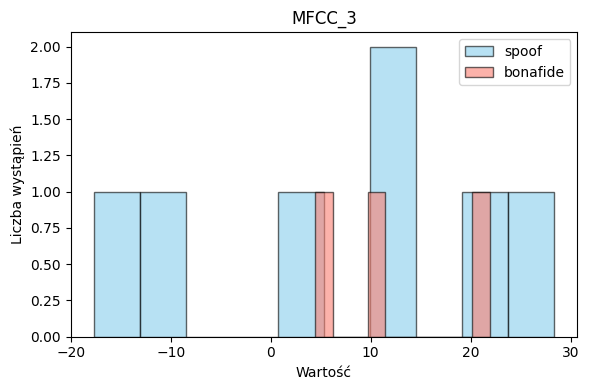

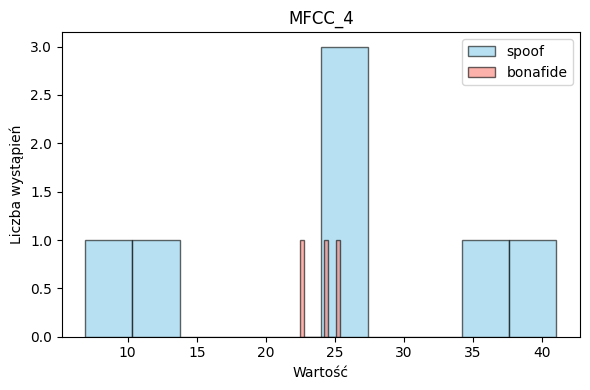

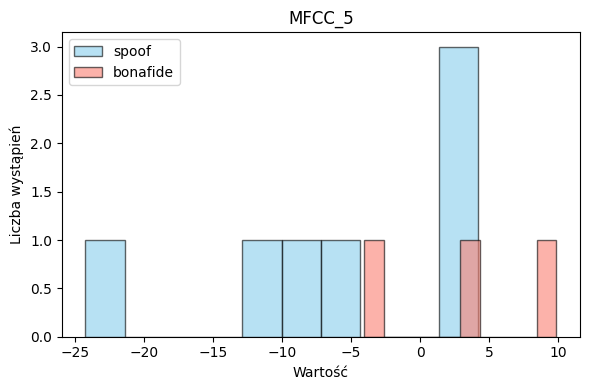

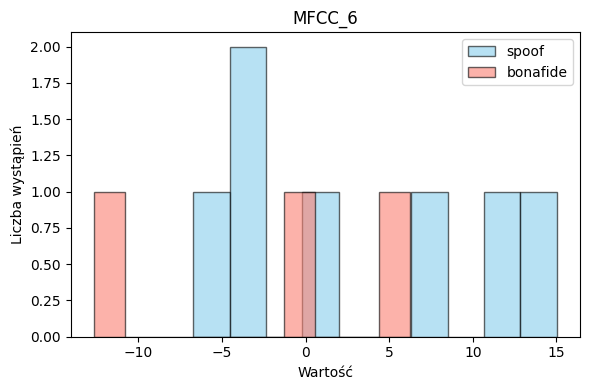

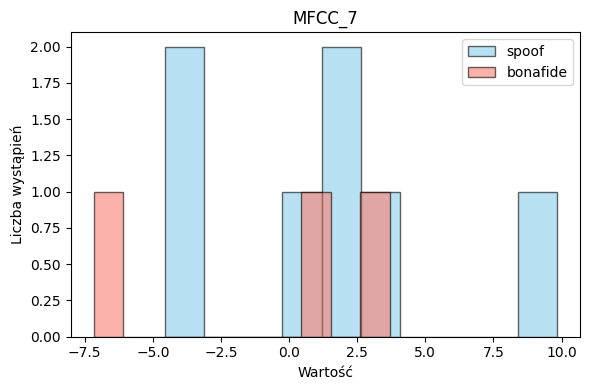

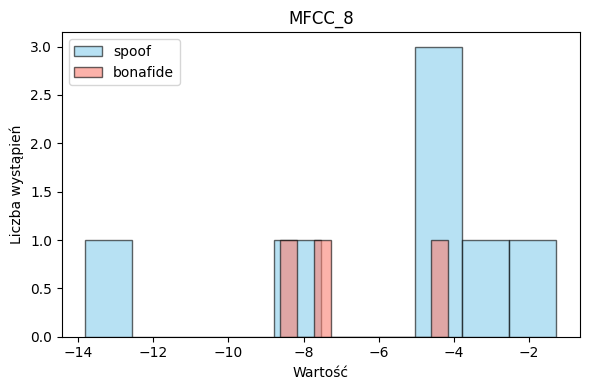

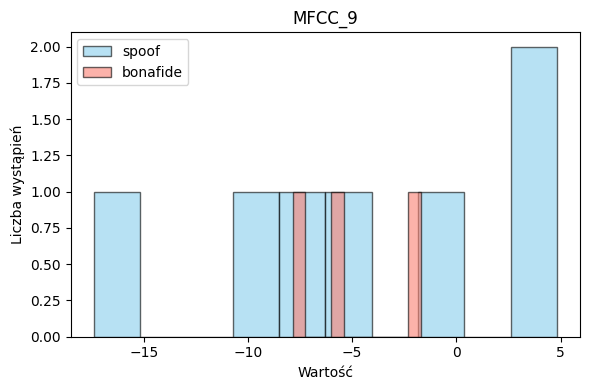

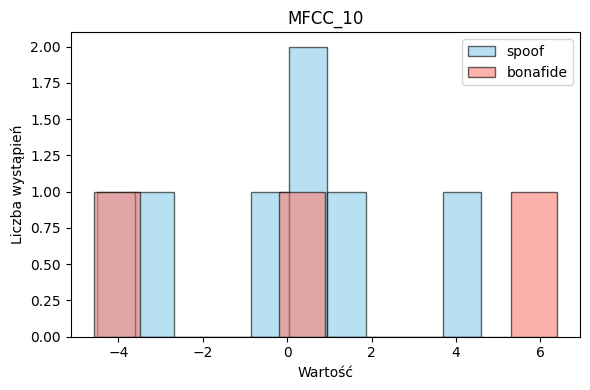

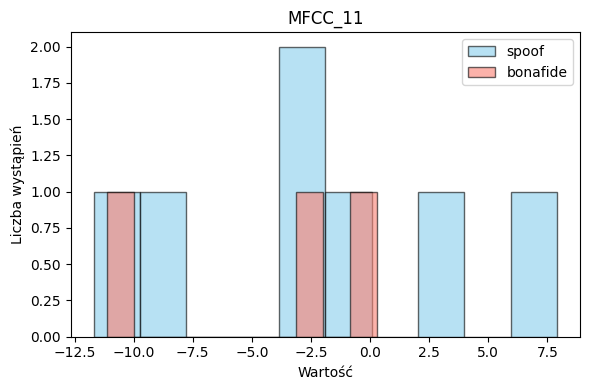

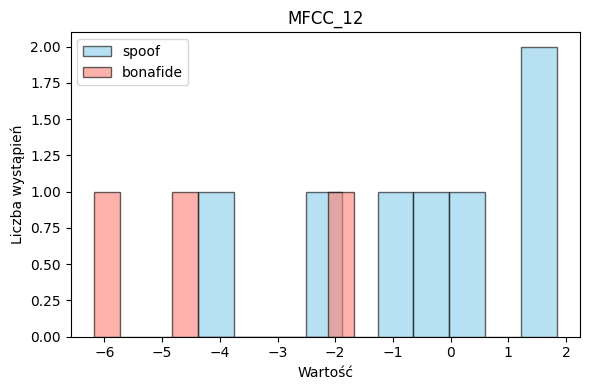

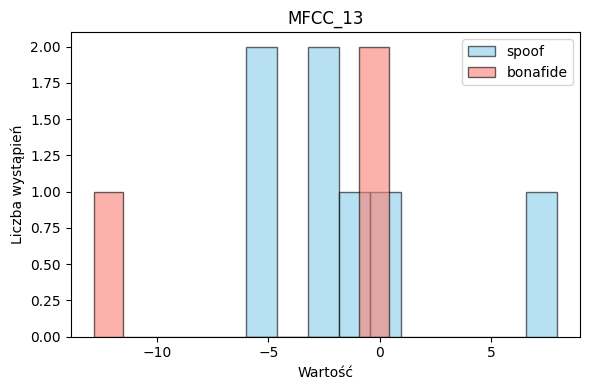

In [14]:
plot_coeff_histograms_by_label_separately(df)

# LFCC – Linear-Frequency Cepstral Coefficients

LFCC (Linear-Frequency Cepstral Coefficients) to współczynniki cepstralne oparte na filtrach 
rozłożonych liniowo w skali częstotliwości, a nie zgodnie ze skalą mel.

Główne cechy LFCC:
- Filtry pokrywają równomiernie cały zakres częstotliwości (np. 0–8000 Hz).
- W przeciwieństwie do MFCC, nie naśladują percepcji słuchowej człowieka.
- Każde pasmo traktowane jest z równą wagą, co czyni LFCC bardziej "neutralnym" matematycznie podejściem.
- Są używane m.in. w detekcji spoofingu, gdzie ważna jest dokładność analizy subtelnych różnic w sygnale.

Proces ekstrakcji:
1. FFT (Transformata Fouriera)
2. Filtry w skali liniowej
3. Logarytmowanie widma
4. DCT (Transformata Cosinusowa) – kompresja cech

LFCC dobrze sprawdzają się tam, gdzie nie zależy nam na odwzorowaniu percepcji, lecz na obiektywnej analizie widma.

In [69]:
df['LFCC'] = df['file_path'].apply(lfcc_feat)

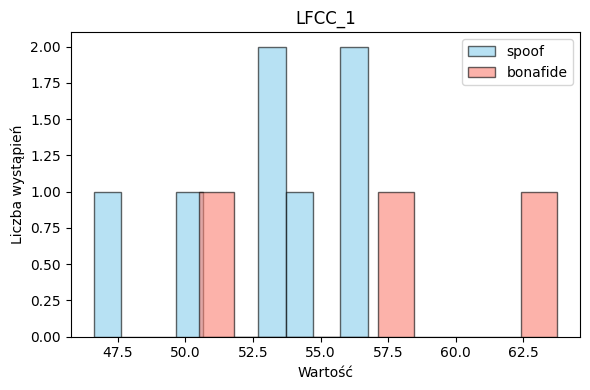

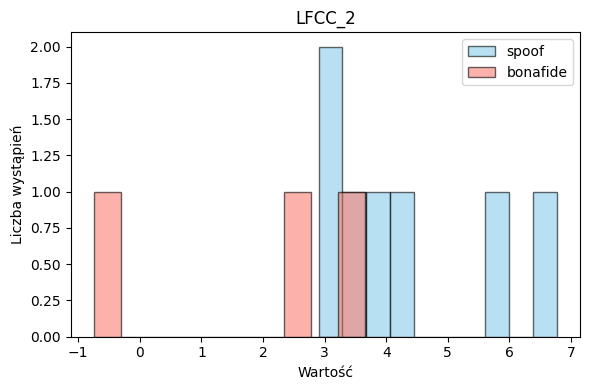

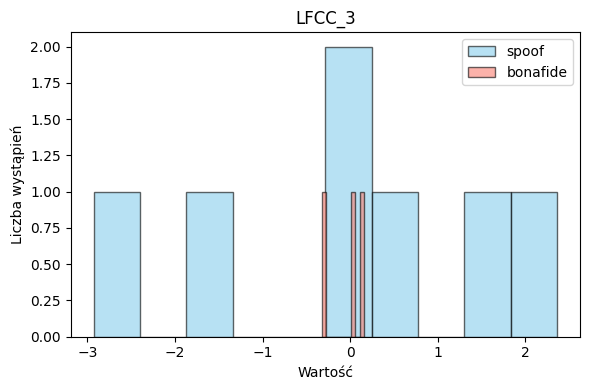

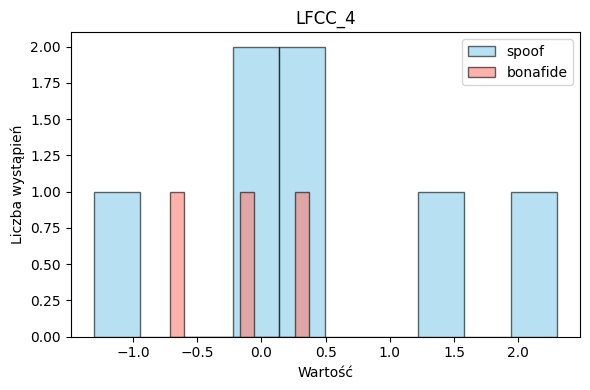

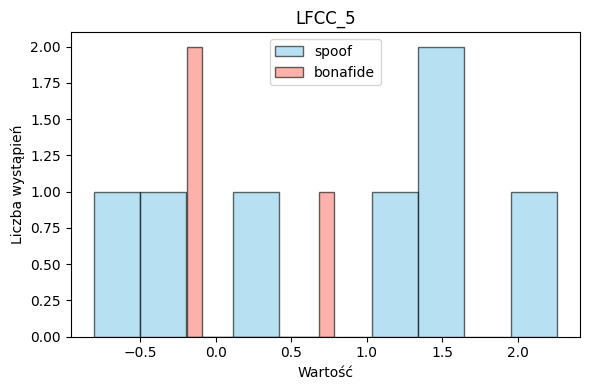

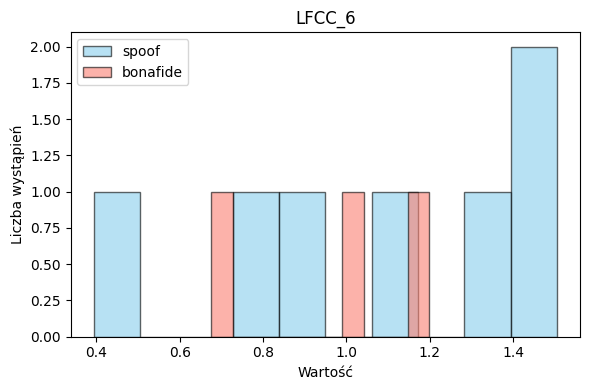

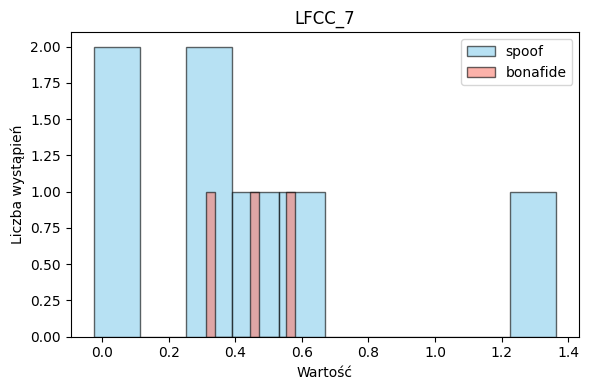

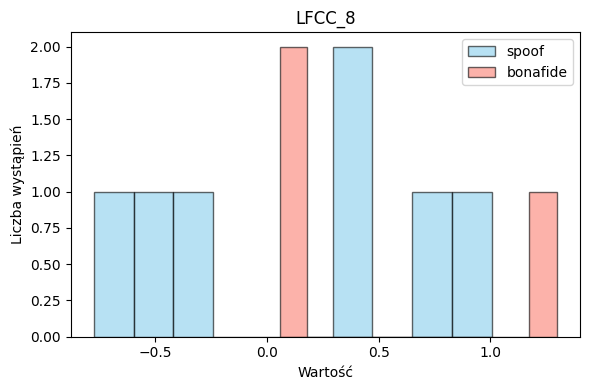

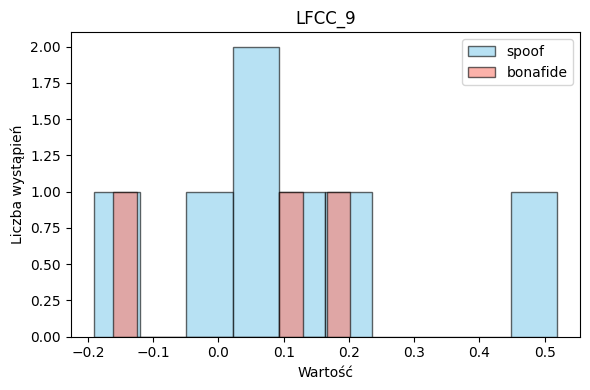

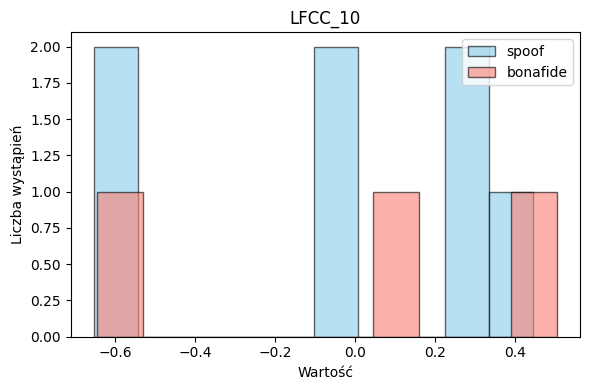

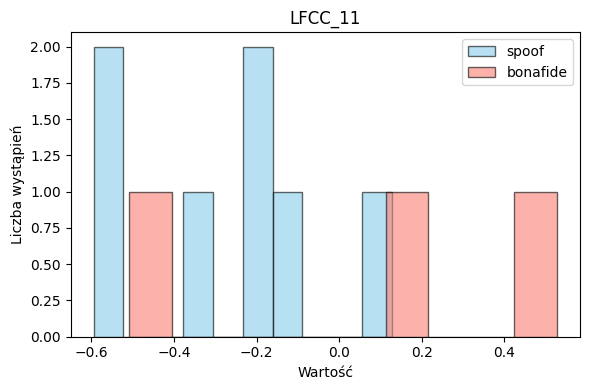

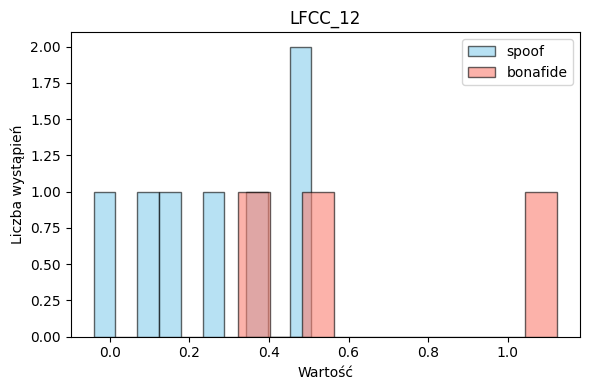

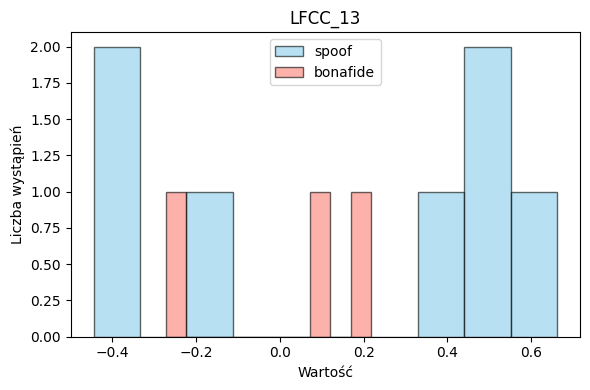

In [17]:
plot_coeff_histograms_by_label_separately(df, 'LFCC')

# CQCC – Constant Q Cepstral Coefficients

CQCC (Constant Q Cepstral Coefficients) to współczynniki cepstralne bazujące na transformacie Constant-Q, 
która zapewnia nieliniowe próbkowanie widma: wyższą rozdzielczość częstotliwościową w niskich pasmach 
oraz lepszą rozdzielczość czasową w pasmach wysokich.

Cechy charakterystyczne:
- CQCC nie są oparte na percepcji słuchowej (jak MFCC), lecz na właściwościach matematycznych CQT.
- Dzięki logarytmicznej skali częstotliwości są bardziej odporne na manipulacje sygnałem.
- Bardzo skuteczne w detekcji spoofingu – m.in. ataków replay, syntezy mowy i konwersji głosu.

Proces ekstrakcji obejmuje:
1. CQT – Constant-Q Transform
2. Logarytmowanie skali widmowej
3. Interpolacja do skali liniowej (opcjonalna standaryzacja)
4. DCT – uzyskanie współczynników cepstralnych

CQCC są uznawane za jedne z najskuteczniejszych cech w zadaniach związanych z bezpieczeństwem audio i detekcją deepfake'ów.

https://arxiv.org/pdf/2004.06422

In [71]:
df['CQCC'] = df['file_path'].apply(extract_cqcc)

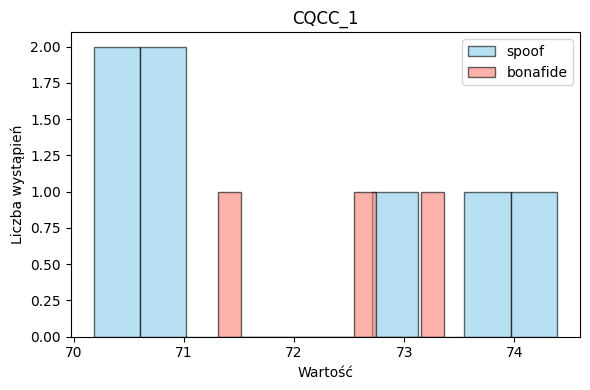

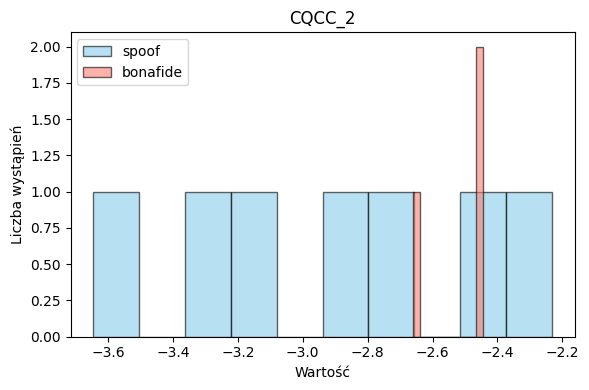

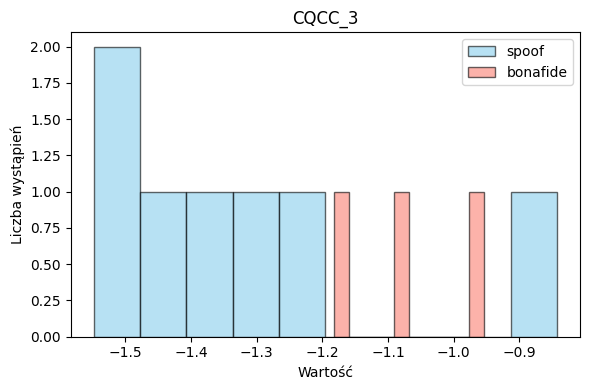

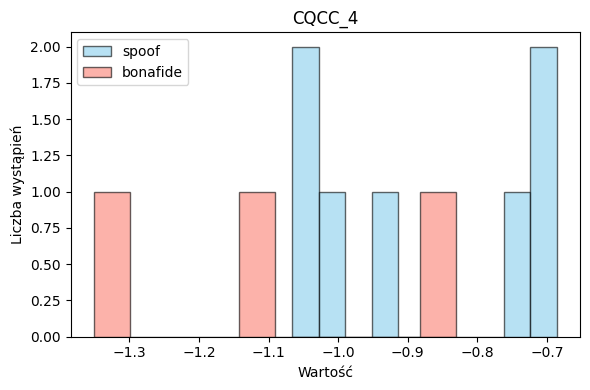

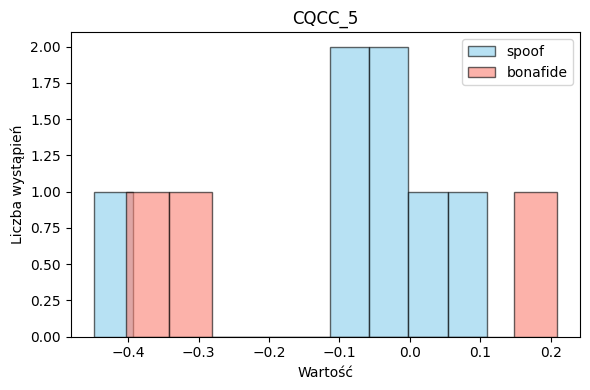

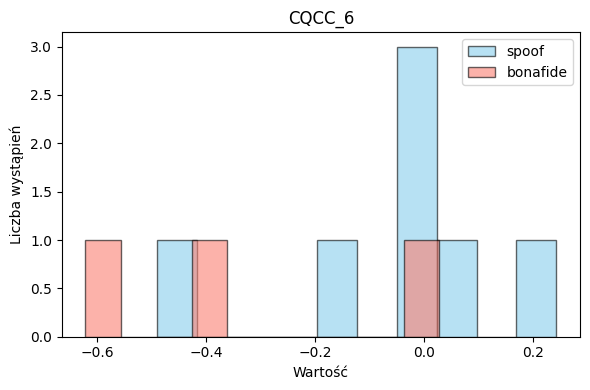

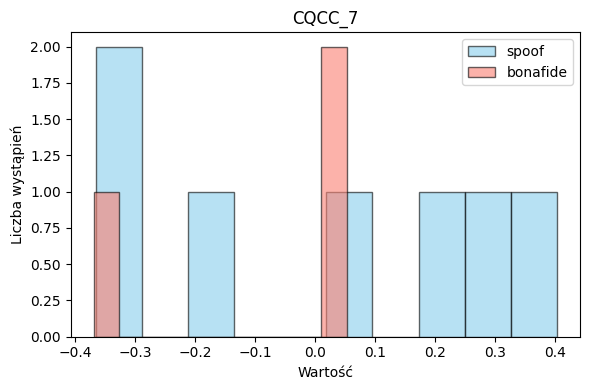

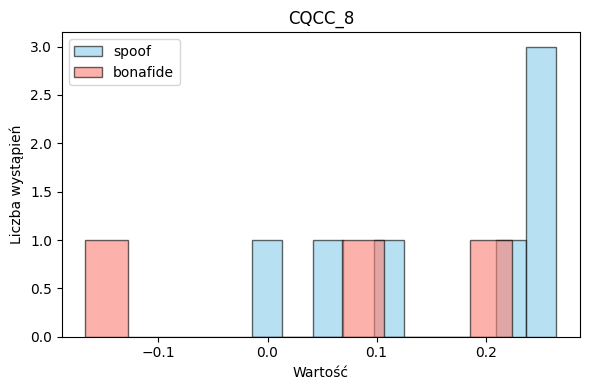

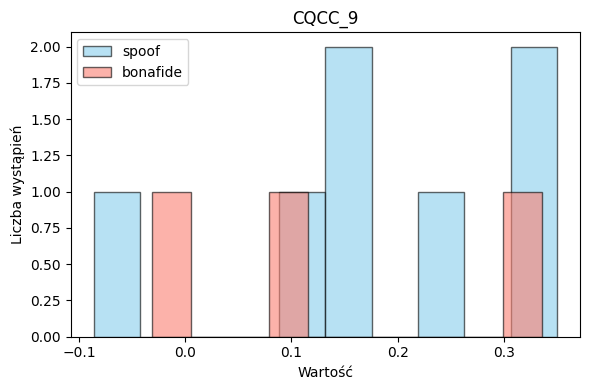

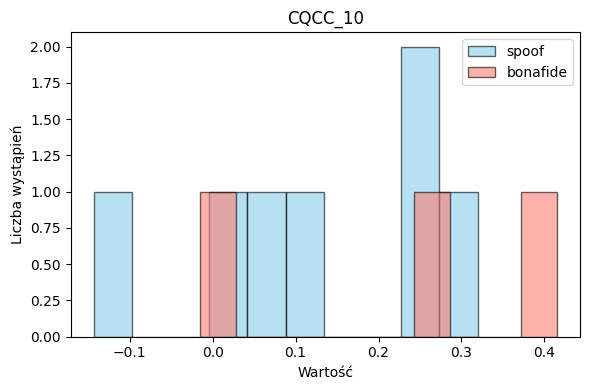

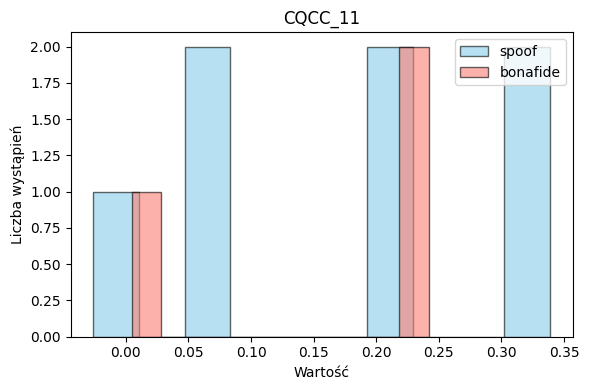

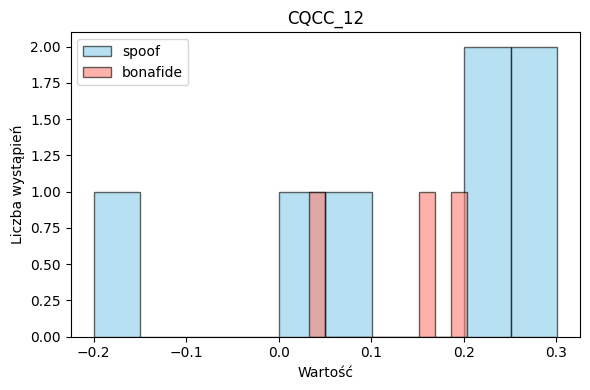

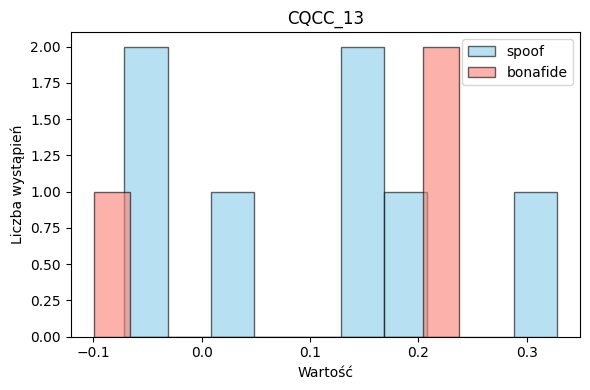

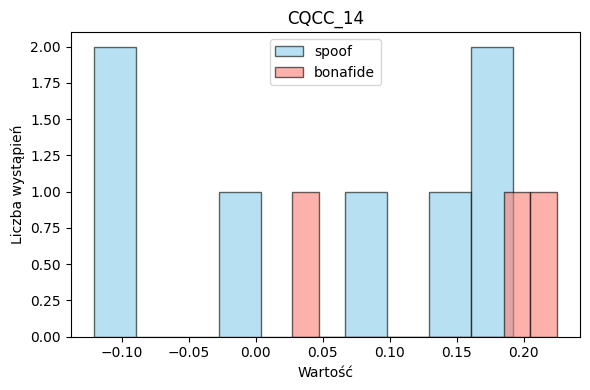

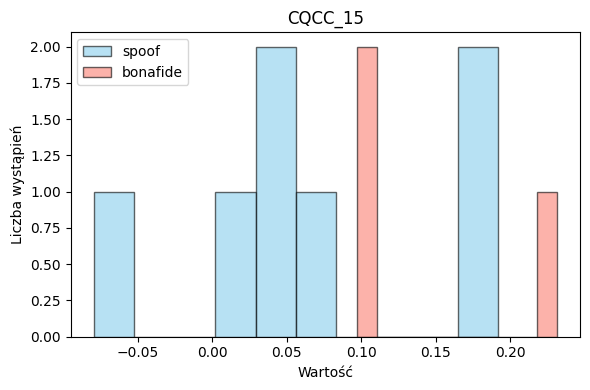

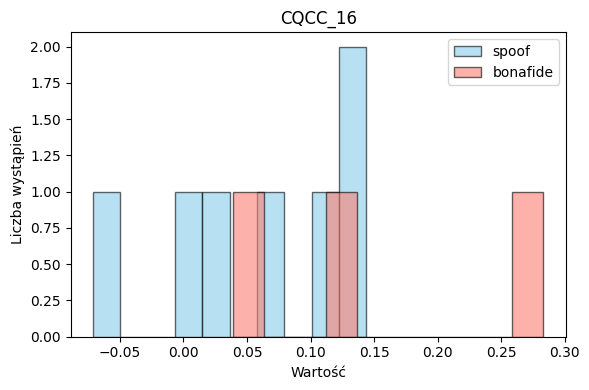

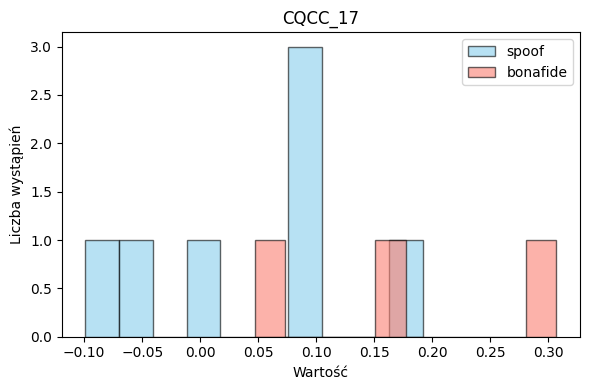

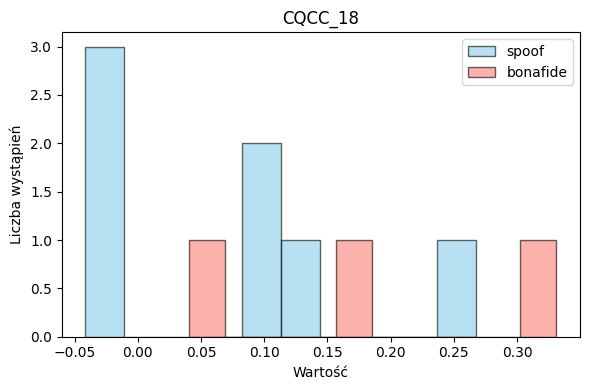

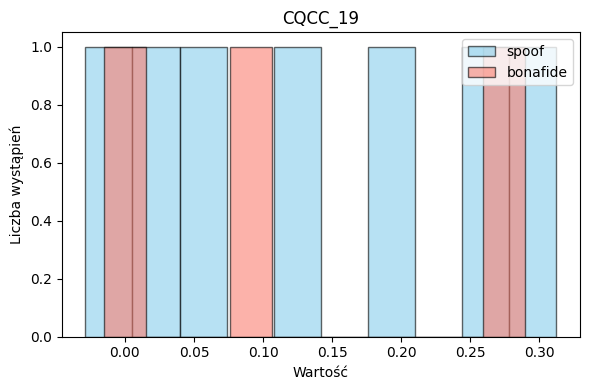

In [35]:
plot_coeff_histograms_by_label_separately(df, 'CQCC') 

# GTCC / GFCC – Gammatone Frequency Cepstral Coefficients

GTCC (znane również jako GFCC – Gammatone Frequency Cepstral Coefficients) to cechy dźwięku
bazujące na filtrach gammatonowych, które imitują działanie ludzkiego ucha wewnętrznego. 
Ich struktura odzwierciedla biologiczne mechanizmy percepcji dźwięku, co czyni je użytecznymi 
w zastosowaniach takich jak rozpoznawanie mowy, identyfikacja mówcy czy detekcja spoofingu.

Etapy ekstrakcji GTCC:
1. **Sygnał mowy** – dane wejściowe w dziedzinie czasu.
2. **Wstępne przetwarzanie** – podział na ramki (20–40 ms), okienkowanie (np. Hamming), pre-emphasis, usunięcie składowej stałej.
3. **DFT** – zamiana każdej ramki na widmo częstotliwościowe (amplituda lub moc).
4. **Filtry Gammatonowe** – biologicznie inspirowane filtry pasmowo-przepustowe, odwzorowujące działanie ślimaka.
5. **Energia subpasmowa** – obliczanie energii sygnału w paśmie każdego filtra.
6. **Logarytmiczna energia** – zastosowanie logarytmu do energii, aby lepiej oddać percepcję głośności.
7. **DCT** – transformata cosinusowa w celu redukcji redundancji i kompresji cech.
8. **Wektor GTCC (GFCC)** – końcowa reprezentacja sygnału: zwarta, biologicznie realistyczna i odporna na zakłócenia.

GTCC oferują bardziej realistyczny model percepcji niż MFCC, szczególnie w kontekście nieliniowych właściwości ludzkiego słuchu.


In [73]:
df['GTCC'] = df['file_path'].apply(compute_gtcc)

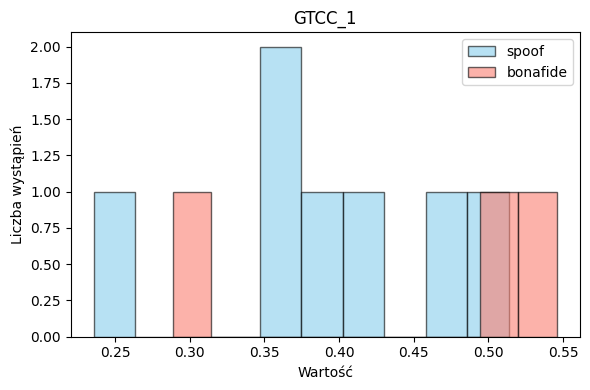

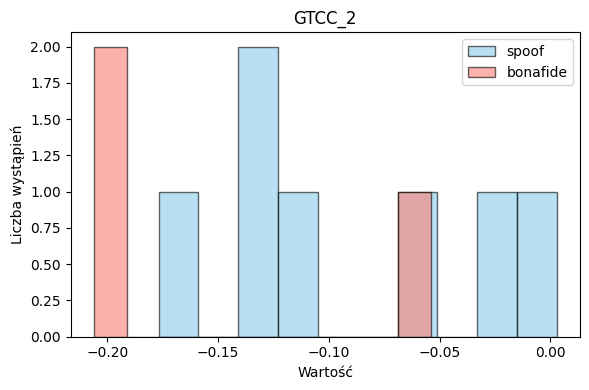

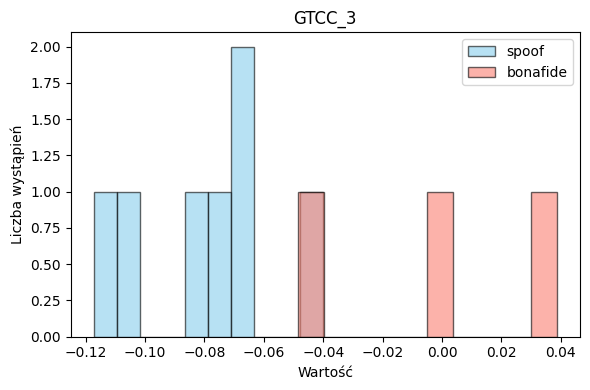

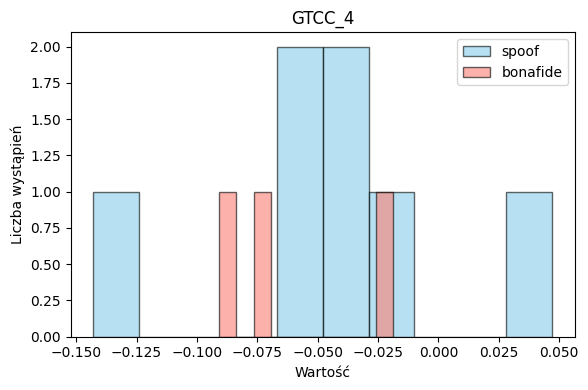

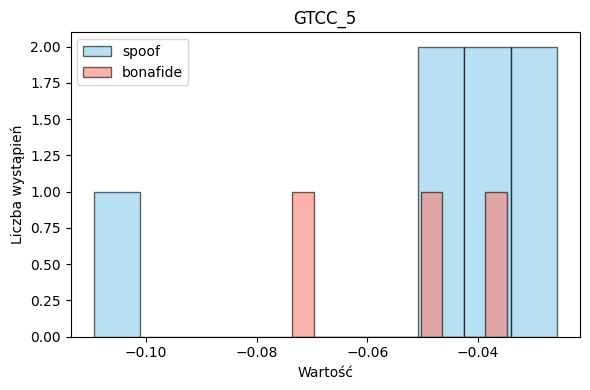

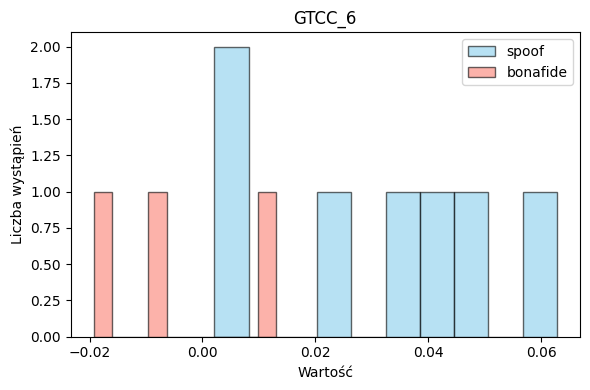

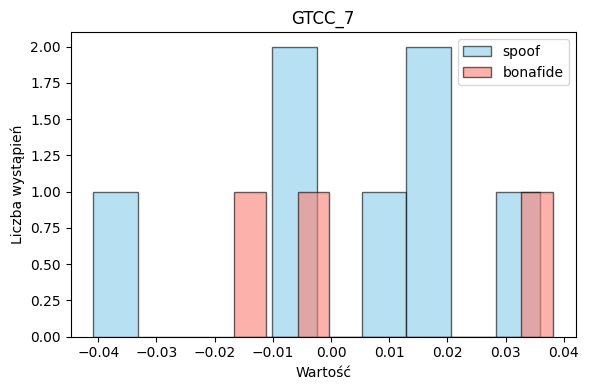

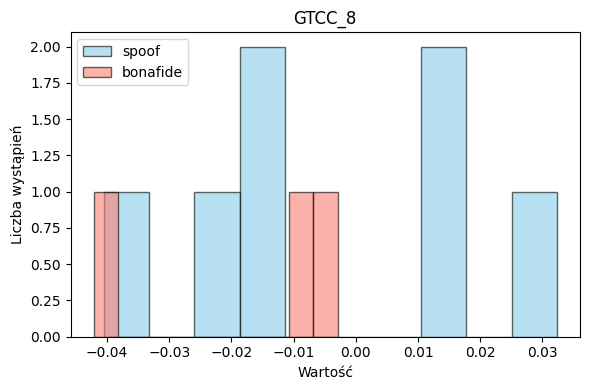

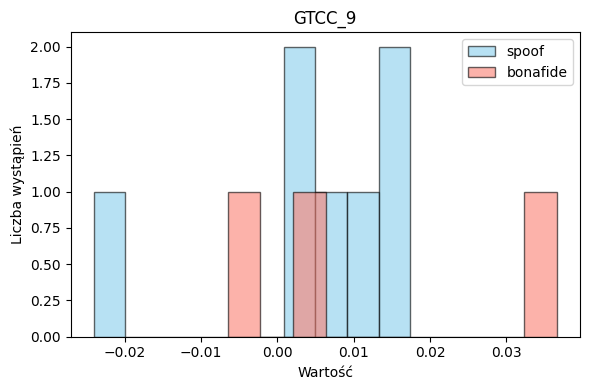

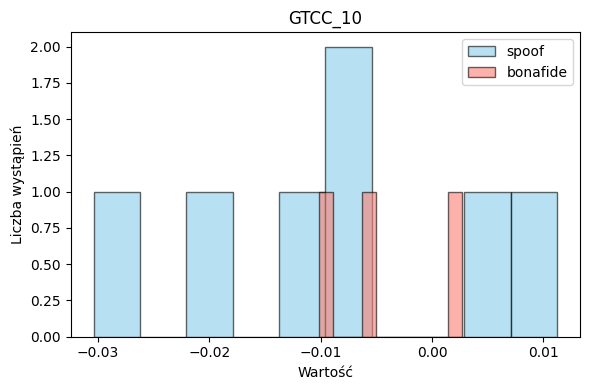

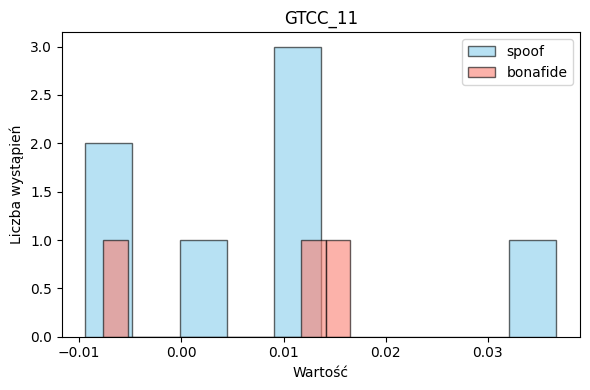

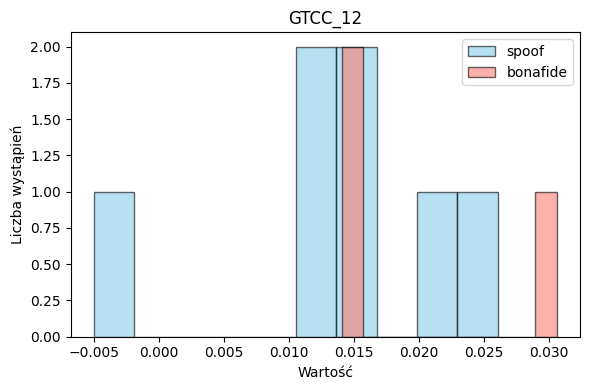

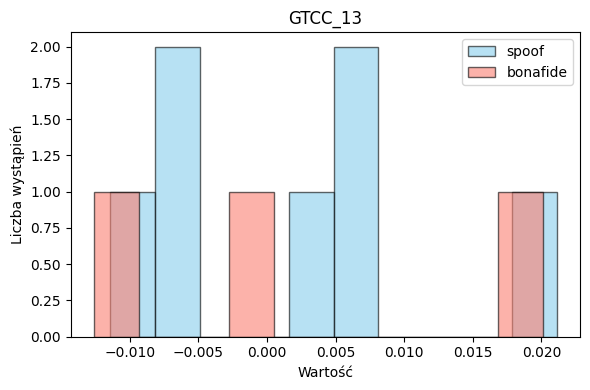

In [44]:
plot_coeff_histograms_by_label_separately(df, 'GTCC')

# WPT – Wavelet Packet Transform

WPT (Wavelet Packet Transform) to rozszerzenie klasycznej dyskretnej transformaty falkowej (DWT), 
które pozwala na bardziej szczegółową i elastyczną analizę sygnału.

Cechy charakterystyczne:
- W klasycznej DWT tylko sygnał niskoczęstotliwościowy (aproksymacja) podlega dalszemu rozkładowi.
- W WPT rozkładane są zarówno sygnały niskoczęstotliwościowe, jak i wysokoczęstotliwościowe (detale).
- Pozwala to uzyskać pełniejsze pokrycie pasma częstotliwości i bardziej precyzyjną analizę struktury sygnału.

Zalety:
- Wysoka rozdzielczość zarówno w niskich, jak i wysokich częstotliwościach.
- Efektywna reprezentacja dla sygnałów nieliniowych i niestacjonarnych, takich jak mowa.
- Wykorzystywana w analizie akustycznej, kompresji danych i detekcji anomalii, np. w zadaniach wykrywania deepfake’ów audio.

Transformata WPT generuje tzw. **drzewo falkowe**, które można wykorzystać do ekstrakcji cech opartych na rozkładzie energii lub statystykach podpasma.


In [77]:
df['WPT'] = df['file_path'].apply(compute_wpt)

# Silence

In [81]:
df['silent'] = df['file_path'].apply(analyze_formants_and_vtl)

# cechy pomysl:
---

### 1. **Korelacje liniowe i monotoniczne**

| Metoda            | Typ zależności | Opis                                                                       |
| ----------------- | -------------- | -------------------------------------------------------------------------- |
| **Pearson**       | Liniowa        | Mierzy liniowy związek między zmiennymi ciągłymi                           |
| **Spearman**      | Monotoniczna   | Mierzy, czy zmienne rosną lub maleją razem (nieliniowy trend monotoniczny) |
| **Kendall’s Tau** | Monotoniczna   | Mierzy zgodność rang między dwiema zmiennymi                               |

---

### 2. **Miary nieliniowej zależności**

| Metoda                                    | Typ danych | Opis                                                                                                  |
| ----------------------------------------- | ---------- | ----------------------------------------------------------------------------------------------------- |
| **Mutual Information (MI)**               | Dowolne    | Mierzy ilość informacji wspólnej między cechą a etykietą (nieliniowa zależność, o dowolnym kształcie) |
| **Maximal Information Coefficient (MIC)** | Dowolne    | Detekcja relacji dowolnego typu (liniowe, krzywoliniowe, skokowe itp.)                                |
| **Hoeffding's D**                         | Ciągłe     | Miara wykrywająca ogólne zależności, nawet bardzo nieliniowe                                          |

---

### 3. **Testy statystyczne zależności cecha–etykieta**

| Test                 | Kiedy stosować                           | Opis                                                               |
| -------------------- | ---------------------------------------- | ------------------------------------------------------------------ |
| **Chi-kwadrat (χ²)** | cechy kategoryczne vs label kategoryczny | Bada statystyczną zależność między zmiennymi kategorycznymi        |
| **ANOVA**            | cecha ciągła vs label kategoryczny       | Testuje, czy średnie cechy różnią się między klasami               |
| **Kruskal–Wallis**   | cecha ciągła vs label kategoryczny       | Nieliniowa wersja ANOVA, gdy dane nie są normalne                  |
| **t-test**           | cecha ciągła vs binarny label            | Porównuje średnie dwóch grup (np. pozytywna vs negatywna etykieta) |

---

### 4. **Modele predykcyjne jako narzędzie analizy zależności**

| Metoda                               | Opis                                                                                |
| ------------------------------------ | ----------------------------------------------------------------------------------- |
| **Drzewa decyzyjne**                 | Pokazują nieliniowe zależności, ważność cech                                        |
| **Random Forest Feature Importance** | Mierzy wpływ cech na poprawność predykcji                                           |
| **Permutation Importance**           | Sprawdza spadek skuteczności modelu po permutacji wartości danej cechy              |
| **Partial Dependence Plots (PDP)**   | Pokazuje wpływ danej cechy na przewidywaną etykietę przy uwzględnieniu innych cech  |
| **SHAP / LIME**                      | Wyjaśnialność modelu: wpływ konkretnej cechy na decyzję modelu dla danej obserwacji |

---

### 5. **Wizualizacje zależności**

* **Scatter plot (wykres rozrzutu)** – z kolorowaniem według labelu
* **Boxplot / Violinplot** – pokazuje rozkład cechy w różnych klasach
* **Correlation matrix / Heatmap** – dla wielu cech na raz
* **t-SNE / UMAP** – nieliniowa redukcja wymiarów z wizualizacją klas

---

### 6. **Miary zależności dla cech mieszanych**

| Narzędzie                      | Do czego służy                                            |
| ------------------------------ | --------------------------------------------------------- |
| **Cramér’s V**                 | Zależność między dwiema zmiennymi kategorycznymi          |
| **Point Biserial Correlation** | Między zmienną ciągłą a binarną                           |
| **Eta-squared (η²)**           | Proporcja wariancji wyjaśniana przez zmienną kategoryczną |

---


# Mel-spektogram

Ludzie postrzegają głośność dźwięku (amplitudę) w sposób logarytmiczny – nie liniowy.

Skala decybelowa (dB) przekształca amplitudę, aby odzwierciedlić percepcję głośności:
0 dB = cisza,
10 dB = 10× głośniejszy,
20 dB = 100× głośniejszy itd.

Użycie tej skali pozwala lepiej odwzorować różnice głośności postrzegane przez człowieka.

In [ ]:
def compute_melspec(row, n_mels=128, hop_length=512, n_fft=2048):
    
    y, sr = librosa.load(row, sr=None)

    mel_spec = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=n_mels,
        hop_length=hop_length,
        n_fft=n_fft,
        power=2.0
    )

    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    mel_spec_db_norm = (mel_spec_db - mel_spec_db.mean()) / mel_spec_db.std()

    return mel_spec_db_norm

# CQT spektogram



In [ ]:
def compute_cqt_spec(row, n_bins=108, bins_per_octave=36):
    
    y, sr = librosa.load(row, sr=None)

    cqt = librosa.cqt(y, sr=sr, n_bins=n_bins, bins_per_octave=bins_per_octave)
    cqt_mag = np.abs(cqt)

    cqt_db = librosa.amplitude_to_db(cqt_mag, ref=np.max)

    cqt_db_norm = (cqt_db - cqt_db.mean()) / cqt_db.std()
    
    return cqt_db_norm